# SRE Agent - ML Model Exploration & Training
## Binary Classification: Anomaly Detection

This notebook covers:
1. Data Loading & Exploration
2. Data Preprocessing & Feature Engineering
3. Model Training (Binary Classification)
4. Model Evaluation
5. Model Saving for Production

# 1. Imports

In [24]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    f1_score,
    accuracy_score
)

# For model saving
import joblib
import pickle

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


# 2. Data Loading 

In [25]:
# Load the training data
with open('../../data/synthetic/training/logs.json', 'r') as f:
    logs_data = json.load(f)

# Load metadata
with open('../../data/synthetic/training/metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"📊 Dataset loaded successfully!")
print(f"Total logs: {len(logs_data)}")
print(f"\nMetadata:")
print(f"- Normal logs: {metadata['normal_logs']}")
print(f"- Anomaly logs: {metadata['anomaly_logs']}")
print(f"- Balance ratio: {metadata['balance_ratio']}")
print(f"- Services: {len(metadata['services'])} unique services")
print(f"- Anomaly types: {metadata['anomaly_types']}")

📊 Dataset loaded successfully!
Total logs: 7000

Metadata:
- Normal logs: 3500
- Anomaly logs: 3500
- Balance ratio: 50:50
- Services: 10 unique services
- Anomaly types: ['high_cpu', 'high_latency', 'disk_issue', 'network_issue', 'connection_pool', 'high_error_rate', 'high_memory']


In [26]:
# Convert to DataFrame
df = pd.DataFrame(logs_data)

# Display basic info
print("DataFrame shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)
print("\nFirst 3 rows:")
df.head(3)

DataFrame shape: (7000, 13)

Column types:
timestamp         object
service           object
level             object
request_id        object
host              object
environment       object
metrics           object
anomaly             bool
message           object
user_id           object
transaction_id    object
anomaly_type      object
stack_trace       object
dtype: object

First 3 rows:


,timestamp,service,level,request_id,host,environment,metrics,anomaly,message,user_id,transaction_id,anomaly_type,stack_trace
0,2025-08-05T18:08:43.135243,database-primary,WARNING,req_068b4715b274,database-primary-1.prod.internal,production,"{'cpu_usage': 44.504101173714716, 'memory_usag...",False,Retry attempt 1 of 3,user_5261,tx_f2ca6aad,NaN,NaN
1,2025-08-05T18:10:43.135243,api-gateway,INFO,req_9c1fc9e46018,api-gateway-2.prod.internal,production,"{'cpu_usage': 48.59803892525282, 'memory_usage...",False,Health check passed,user_6514,tx_38810303,NaN,NaN
2,2025-08-05T18:12:43.135243,payment-service,INFO,req_d8caf74658a4,payment-service-3.prod.internal,production,"{'cpu_usage': 24.560893291287297, 'memory_usag...",False,Database connection pool healthy,user_7272,tx_df50a64c,NaN,NaN


# 3. Data Exploration

In [27]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print("\nNote: user_id and transaction_id are expected to have missing values (optional fields)")

Missing values per column:
timestamp            0
service              0
level                0
request_id           0
host                 0
environment          0
metrics              0
anomaly              0
message              0
user_id           2090
transaction_id    3500
anomaly_type      3500
stack_trace       4896
dtype: int64

Note: user_id and transaction_id are expected to have missing values (optional fields)


In [28]:
# Explore the metrics column (nested JSON)
print("Sample metrics structure:")
print(json.dumps(df['metrics'].iloc[0], indent=2))

# Extract metrics into separate columns
metrics_df = pd.json_normalize(df['metrics'])
print(f"\nMetrics columns: {list(metrics_df.columns)}")

Sample metrics structure:
{
  "cpu_usage": 44.504101173714716,
  "memory_usage": 64.15618994038454,
  "disk_usage": 43.03423339238549,
  "network_in_mbps": 85.94652393537483,
  "network_out_mbps": 78.35477664736817,
  "active_connections": 143,
  "request_latency_ms": 85,
  "requests_per_second": 409,
  "error_rate": 0.009112320474597447
}

Metrics columns: ['cpu_usage', 'memory_usage', 'disk_usage', 'network_in_mbps', 'network_out_mbps', 'active_connections', 'request_latency_ms', 'requests_per_second', 'error_rate']


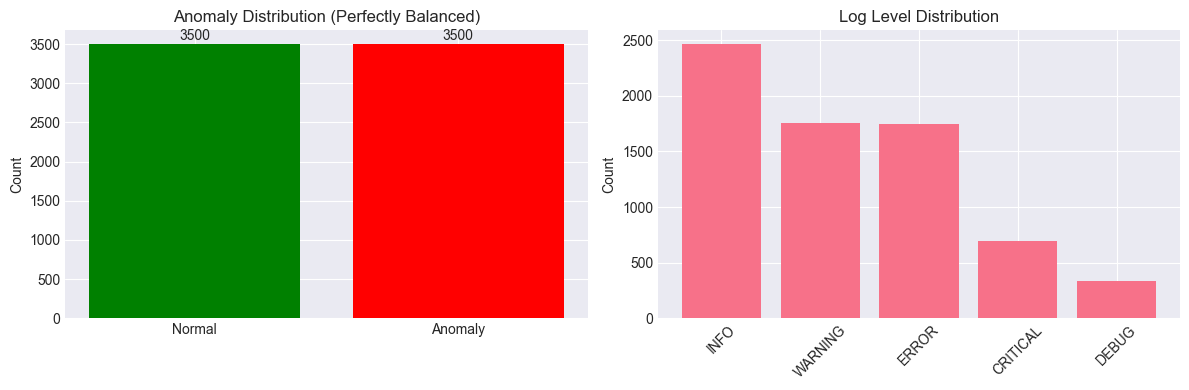

In [29]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Anomaly distribution
anomaly_counts = df['anomaly'].value_counts()
axes[0].bar(['Normal', 'Anomaly'], anomaly_counts.values, color=['green', 'red'])
axes[0].set_title('Anomaly Distribution (Perfectly Balanced)')
axes[0].set_ylabel('Count')
for i, v in enumerate(anomaly_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center')

# Log level distribution
level_counts = df['level'].value_counts()
axes[1].bar(level_counts.index, level_counts.values)
axes[1].set_title('Log Level Distribution')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(level_counts.index, rotation=45)

plt.tight_layout()
plt.show()

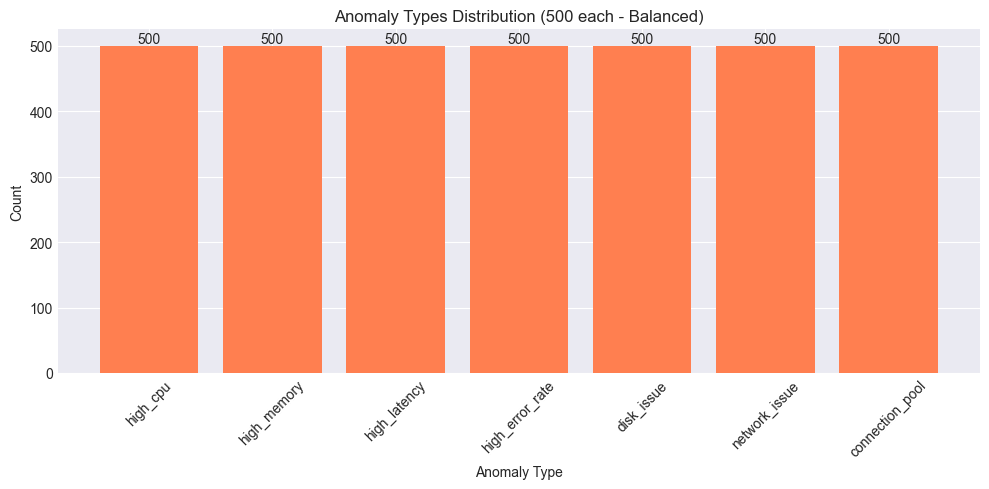

In [30]:
# Explore anomaly types distribution
anomaly_df = df[df['anomaly'] == True].copy()
anomaly_type_counts = anomaly_df['anomaly_type'].value_counts()

plt.figure(figsize=(10, 5))
plt.bar(anomaly_type_counts.index, anomaly_type_counts.values, color='coral')
plt.title('Anomaly Types Distribution (500 each - Balanced)')
plt.xlabel('Anomaly Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
for i, v in enumerate(anomaly_type_counts.values):
    plt.text(i, v + 5, str(v), ha='center')
plt.tight_layout()
plt.show()

# 4. Feature Engineering and Preprocessing

In [31]:
# Create feature matrix
def create_features(df):
    """
    Extract and engineer features from the log data
    """
    features = pd.DataFrame()
    
    # 1. Extract all metrics as features
    metrics_df = pd.json_normalize(df['metrics'])
    features = pd.concat([features, metrics_df], axis=1)
    
    # 2. Encode service names
    service_encoder = LabelEncoder()
    features['service_encoded'] = service_encoder.fit_transform(df['service'])
    
    # 3. Encode log levels
    level_map = {'DEBUG': 0, 'INFO': 1, 'WARNING': 2, 'ERROR': 3, 'CRITICAL': 4}
    features['level_encoded'] = df['level'].map(level_map)
    
    # 4. Time-based features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    features['hour'] = df['timestamp'].dt.hour
    features['day_of_week'] = df['timestamp'].dt.dayofweek
    features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)
    
    # 5. Composite features
    features['cpu_memory_product'] = features['cpu_usage'] * features['memory_usage'] / 100
    features['system_load'] = (features['cpu_usage'] + features['memory_usage'] + features['disk_usage']) / 3
    features['network_imbalance'] = abs(features['network_in_mbps'] - features['network_out_mbps'])
    features['latency_to_rps_ratio'] = features['request_latency_ms'] / (features['requests_per_second'] + 1)
    
    # 6. Binary flags
    features['has_user_id'] = df['user_id'].notna().astype(int)
    features['has_transaction_id'] = df['transaction_id'].notna().astype(int)
    
    # 7. Statistical features (for production, these would be computed over time windows)
    features['high_cpu_flag'] = (features['cpu_usage'] > 80).astype(int)
    features['high_memory_flag'] = (features['memory_usage'] > 80).astype(int)
    features['high_error_flag'] = (features['error_rate'] > 0.05).astype(int)
    
    return features, service_encoder

# Create features
X, service_encoder = create_features(df)
y = df['anomaly'].astype(int)  # Convert boolean to 0/1

print(f"Feature matrix shape: {X.shape}")
print(f"Features created: {X.shape[1]}")
print(f"\nFeature names:")
print(list(X.columns))

Feature matrix shape: (7000, 23)
Features created: 23

Feature names:
['cpu_usage', 'memory_usage', 'disk_usage', 'network_in_mbps', 'network_out_mbps', 'active_connections', 'request_latency_ms', 'requests_per_second', 'error_rate', 'service_encoded', 'level_encoded', 'hour', 'day_of_week', 'is_weekend', 'cpu_memory_product', 'system_load', 'network_imbalance', 'latency_to_rps_ratio', 'has_user_id', 'has_transaction_id', 'high_cpu_flag', 'high_memory_flag', 'high_error_flag']


In [35]:
# Check for any missing values in features
print("Missing values in features:")
missing_counts = X.isnull().sum()
if missing_counts.sum() == 0:
    print("✅ No missing values in feature matrix!")
else:
    print(missing_counts[missing_counts > 0])
    # Handle missing values if any
    X = X.fillna(0)  # Simple imputation with 0
    print("Missing values filled with 0")

Missing values in features:
✅ No missing values in feature matrix!


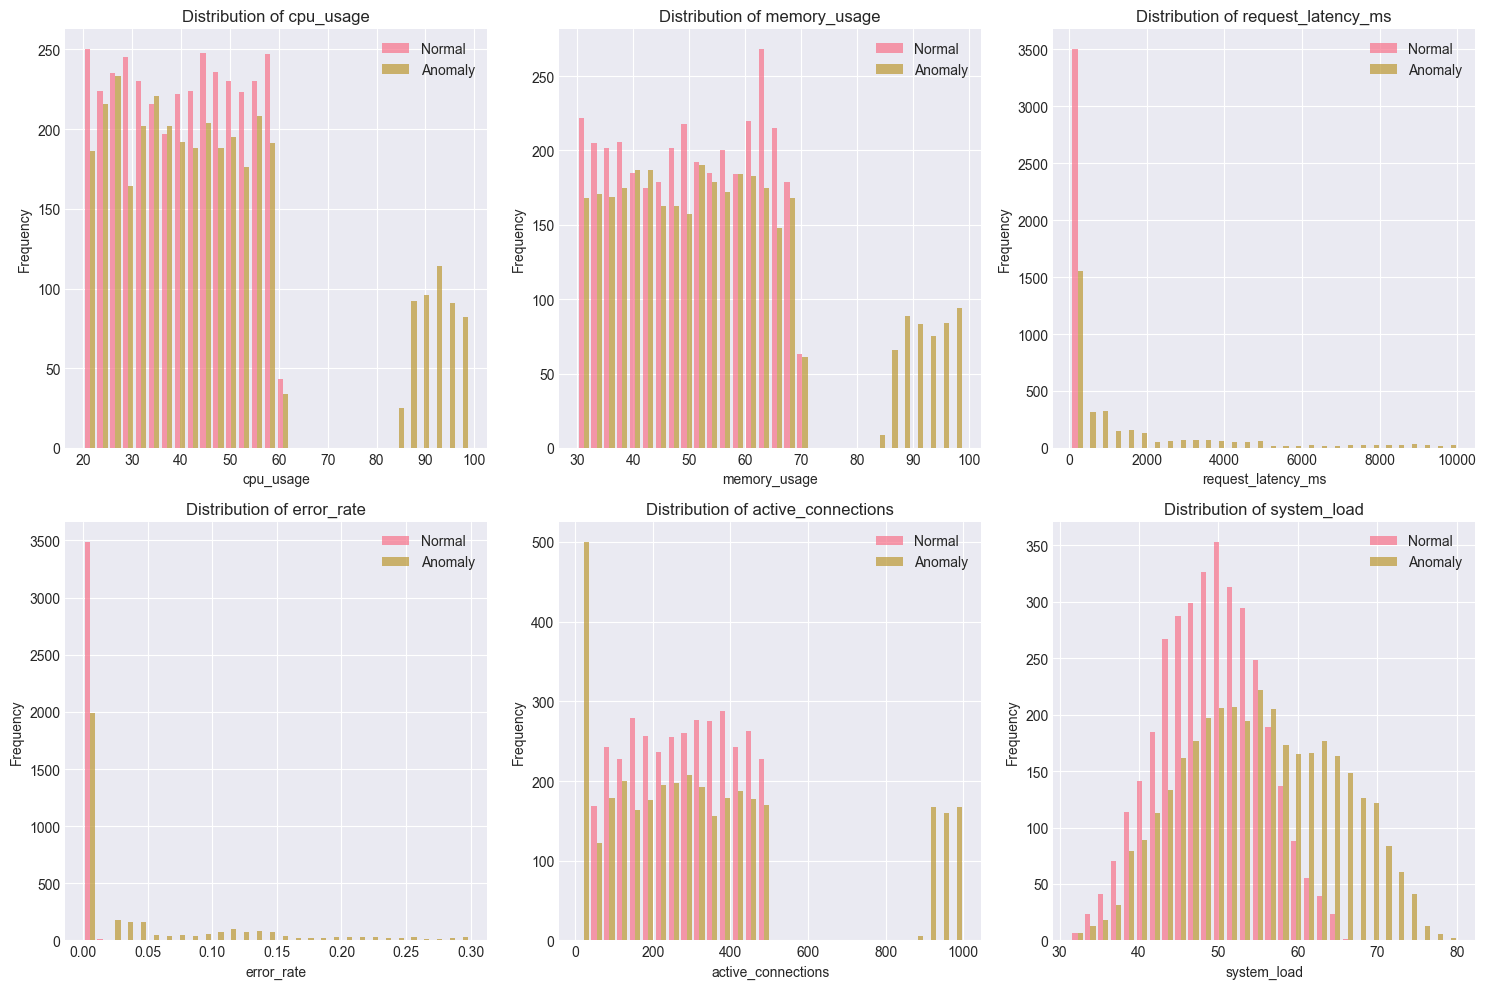

In [36]:
# Visualize feature distributions for normal vs anomaly
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

key_features = ['cpu_usage', 'memory_usage', 'request_latency_ms', 
                'error_rate', 'active_connections', 'system_load']

for idx, feature in enumerate(key_features):
    normal_data = X[y == 0][feature]
    anomaly_data = X[y == 1][feature]
    
    axes[idx].hist([normal_data, anomaly_data], bins=30, label=['Normal', 'Anomaly'], alpha=0.7)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'Distribution of {feature}')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# 5. Train Test Split

In [37]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nClass distribution in training set:")
print(f"- Normal: {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"- Anomaly: {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nClass distribution in test set:")
print(f"- Normal: {sum(y_test == 0)} ({sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"- Anomaly: {sum(y_test == 1)} ({sum(y_test == 1)/len(y_test)*100:.1f}%)")

Training set size: 5600 samples
Test set size: 1400 samples

Class distribution in training set:
- Normal: 2800 (50.0%)
- Anomaly: 2800 (50.0%)

Class distribution in test set:
- Normal: 700 (50.0%)
- Anomaly: 700 (50.0%)


In [38]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"Scaled training shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

✅ Features scaled using StandardScaler
Scaled training shape: (5600, 23)
Scaled test shape: (1400, 23)


# 6. Model Training (Multiple Approaches)

### 6.1 Isolation Forest (Unsupervised Approach)

In [39]:
# Train Isolation Forest
print("Training Isolation Forest...")

iso_forest = IsolationForest(
    contamination=0.5,  # We know it's 50% anomalies
    random_state=42,
    n_estimators=100
)

# Fit on training data
iso_forest.fit(X_train_scaled)

# Predict (returns -1 for anomalies, 1 for normal)
y_pred_iso = iso_forest.predict(X_test_scaled)
# Convert to 0/1 format (0 for normal, 1 for anomaly)
y_pred_iso_binary = (y_pred_iso == -1).astype(int)

# Evaluate
iso_accuracy = accuracy_score(y_test, y_pred_iso_binary)
iso_f1 = f1_score(y_test, y_pred_iso_binary)

print(f"\nIsolation Forest Results:")
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"F1-Score: {iso_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_iso_binary, target_names=['Normal', 'Anomaly']))

Training Isolation Forest...

Isolation Forest Results:
Accuracy: 0.6907
F1-Score: 0.6970

Classification Report:
              precision    recall  f1-score   support

      Normal       0.70      0.67      0.68       700
     Anomaly       0.68      0.71      0.70       700

    accuracy                           0.69      1400
   macro avg       0.69      0.69      0.69      1400
weighted avg       0.69      0.69      0.69      1400



### 6.2 Random Forest Classifier (Supervised Approach)

In [40]:
# Train Random Forest
print("Training Random Forest Classifier...")

rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit the model
rf_classifier.fit(X_train_scaled, y_train)

# Predict
y_pred_rf = rf_classifier.predict(X_test_scaled)
y_pred_rf_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, y_pred_rf_proba)

print(f"\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Normal', 'Anomaly']))

Training Random Forest Classifier...

Random Forest Results:
Accuracy: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       700
     Anomaly       1.00      1.00      1.00       700

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400



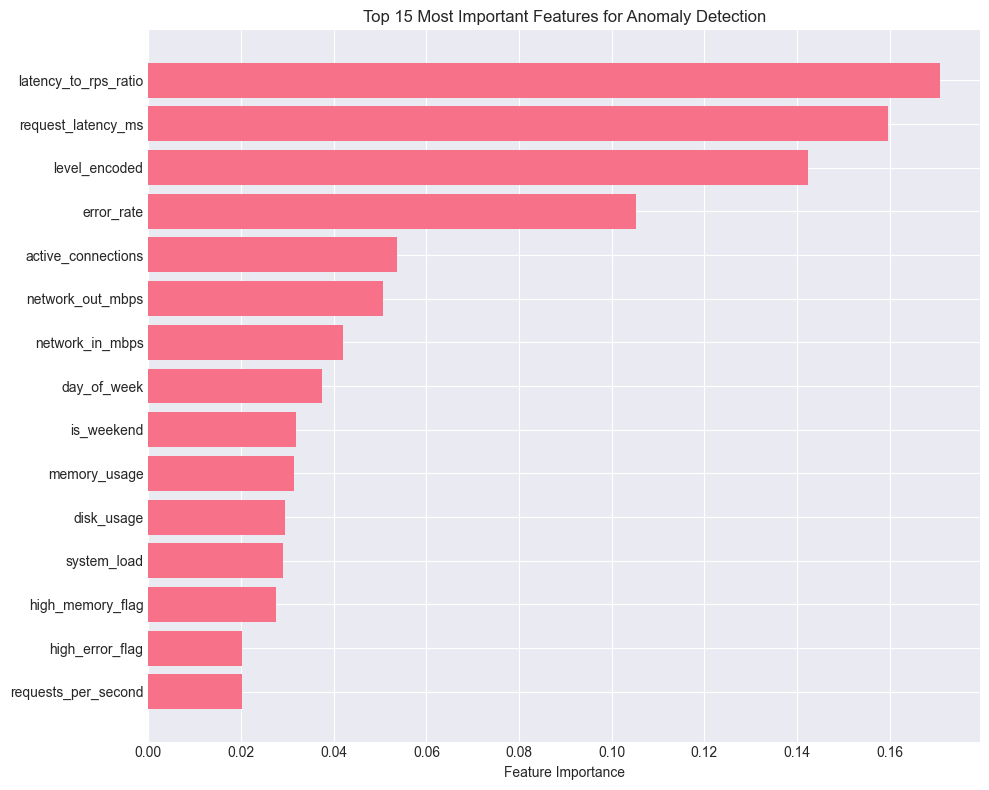

Top 10 features:
                 feature  importance
17  latency_to_rps_ratio    0.170927
6     request_latency_ms    0.159676
10         level_encoded    0.142263
8             error_rate    0.105200
5     active_connections    0.053737
4       network_out_mbps    0.050588
3        network_in_mbps    0.041968
12           day_of_week    0.037450
13            is_weekend    0.031880
1           memory_usage    0.031454


In [41]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features for Anomaly Detection')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(feature_importance.head(10))

### 6.3 Model Comparison & Visualization

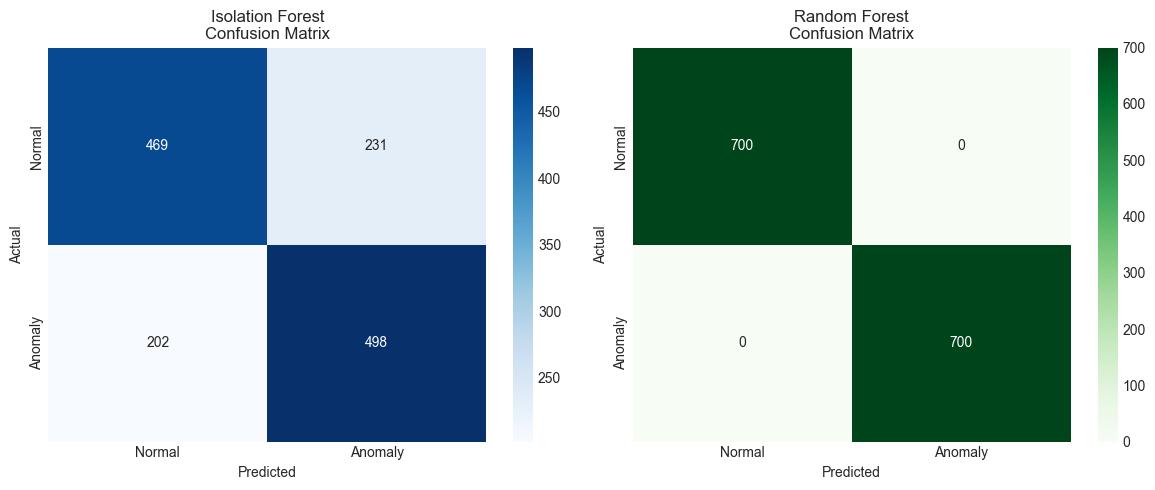

In [42]:
# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Isolation Forest Confusion Matrix
cm_iso = confusion_matrix(y_test, y_pred_iso_binary)
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Isolation Forest\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Normal', 'Anomaly'])
axes[0].set_yticklabels(['Normal', 'Anomaly'])

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Normal', 'Anomaly'])
axes[1].set_yticklabels(['Normal', 'Anomaly'])

plt.tight_layout()
plt.show()

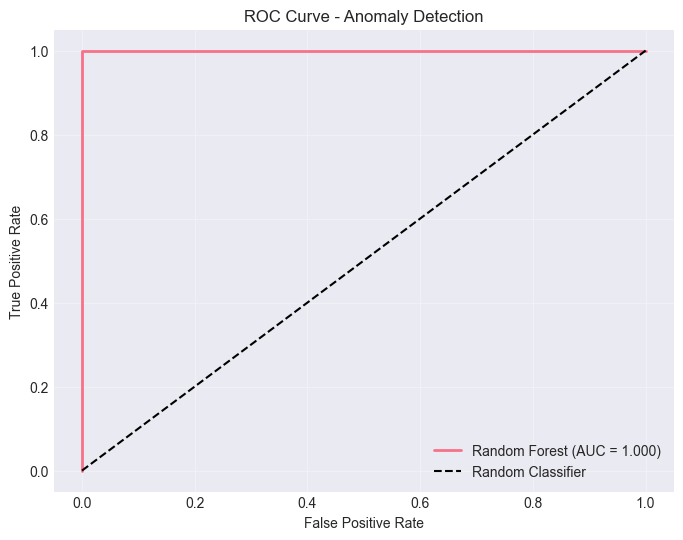

In [43]:
# ROC Curves (only for Random Forest as Isolation Forest doesn't provide probabilities)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {rf_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Anomaly Detection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
# Model Comparison Summary
comparison_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'Random Forest'],
    'Accuracy': [iso_accuracy, rf_accuracy],
    'F1-Score': [iso_f1, rf_f1],
    'AUC-ROC': ['-', rf_auc]  # Isolation Forest doesn't provide probabilities
})

print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(comparison_df.to_string(index=False))
print("="*50)

# Select best model
best_model = 'Random Forest' if rf_f1 > iso_f1 else 'Isolation Forest'
print(f"\n🏆 Best Model: {best_model} (based on F1-Score)")


MODEL COMPARISON SUMMARY
           Model  Accuracy  F1-Score AUC-ROC
Isolation Forest  0.690714  0.696991       -
   Random Forest  1.000000  1.000000     1.0

🏆 Best Model: Random Forest (based on F1-Score)


# 7. Hyperparameter Tuning (Optional - for better performance)

In [45]:
# Optional: Hyperparameter tuning for Random Forest
print("Performing hyperparameter tuning for Random Forest...")
print("This might take a few minutes...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use fewer combinations for faster training
param_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_small,
    cv=3,  # 3-fold cross-validation
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
best_f1 = f1_score(y_test, y_pred_best)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\nTest set performance with best parameters:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"F1-Score: {best_f1:.4f}")

Performing hyperparameter tuning for Random Forest...
This might take a few minutes...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation F1-score: 1.0000

Test set performance with best parameters:
Accuracy: 1.0000
F1-Score: 1.0000


# 8. Final Model Selection and saving

In [46]:
# Select the final model (use the tuned Random Forest if it's better)
if 'best_rf' in locals() and best_f1 > rf_f1:
    final_model = best_rf
    model_name = "Random Forest (Tuned)"
    final_f1 = best_f1
else:
    final_model = rf_classifier
    model_name = "Random Forest"
    final_f1 = rf_f1

print(f"Selected Model: {model_name}")
print(f"Final F1-Score: {final_f1:.4f}")

Selected Model: Random Forest
Final F1-Score: 1.0000


In [48]:
# Save all necessary components
import os

# Create directory for saved models
os.makedirs('../../ml_pipeline/saved_models', exist_ok=True)

# 1. Save the main model
model_path = '../../ml_pipeline/saved_models/anomaly_detector.pkl'
joblib.dump(final_model, model_path)
print(f"✅ Model saved to: {model_path}")

# 2. Save the scaler
scaler_path = '../../ml_pipeline/saved_models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

# 3. Save the service encoder
encoder_path = '../../ml_pipeline/saved_models/service_encoder.pkl'
joblib.dump(service_encoder, encoder_path)
print(f"✅ Service encoder saved to: {encoder_path}")

# 4. Save feature names and model metadata
model_metadata = {
    'model_type': model_name,
    'feature_names': list(X.columns),
    'n_features': X.shape[1],
    'training_date': datetime.now().isoformat(),
    'performance': {
        'accuracy': float(final_model.score(X_test_scaled, y_test)),
        'f1_score': float(final_f1),
        'training_samples': len(X_train),
        'test_samples': len(X_test)
    },
    'services': list(service_encoder.classes_),
    'threshold': 0.5  # Decision threshold for binary classification
}

metadata_path = '../../ml_pipeline/saved_models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)
print(f"✅ Model metadata saved to: {metadata_path}")

print("\n" + "="*50)
print("MODEL TRAINING COMPLETE!")
print("="*50)
print(f"All models and preprocessors saved to: ml_pipeline/saved_models/")
print(f"\nFiles saved:")
print(f"  1. anomaly_detector.pkl - Main model")
print(f"  2. scaler.pkl - Feature scaler")
print(f"  3. service_encoder.pkl - Service name encoder")
print(f"  4. model_metadata.json - Model configuration")

✅ Model saved to: ../../ml_pipeline/saved_models/anomaly_detector.pkl
✅ Scaler saved to: ../../ml_pipeline/saved_models/scaler.pkl
✅ Service encoder saved to: ../../ml_pipeline/saved_models/service_encoder.pkl
✅ Model metadata saved to: ../../ml_pipeline/saved_models/model_metadata.json

MODEL TRAINING COMPLETE!
All models and preprocessors saved to: ml_pipeline/saved_models/

Files saved:
  1. anomaly_detector.pkl - Main model
  2. scaler.pkl - Feature scaler
  3. service_encoder.pkl - Service name encoder
  4. model_metadata.json - Model configuration


# 9. Model Testing - Inference Pipeline

In [50]:
# Test the saved model with a sample prediction
def predict_anomaly(log_entry, model, scaler, service_encoder, feature_names):
    """
    Predict if a single log entry is an anomaly
    """
    # Create a DataFrame from single log entry
    df_single = pd.DataFrame([log_entry])
    
    # Extract features (simplified version)
    features = pd.DataFrame()
    
    # Extract metrics
    metrics_df = pd.json_normalize(df_single['metrics'])
    features = pd.concat([features, metrics_df], axis=1)
    
    # Encode service
    try:
        features['service_encoded'] = service_encoder.transform(df_single['service'])
    except:
        features['service_encoded'] = 0  # Default for unknown services
    
    # Encode level
    level_map = {'DEBUG': 0, 'INFO': 1, 'WARNING': 2, 'ERROR': 3, 'CRITICAL': 4}
    features['level_encoded'] = df_single['level'].map(level_map)
    
    # Time features
    df_single['timestamp'] = pd.to_datetime(df_single['timestamp'])
    features['hour'] = df_single['timestamp'].dt.hour
    features['day_of_week'] = df_single['timestamp'].dt.dayofweek
    features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)
    
    # Composite features
    features['cpu_memory_product'] = features['cpu_usage'] * features['memory_usage'] / 100
    features['system_load'] = (features['cpu_usage'] + features['memory_usage'] + features['disk_usage']) / 3
    features['network_imbalance'] = abs(features['network_in_mbps'] - features['network_out_mbps'])
    features['latency_to_rps_ratio'] = features['request_latency_ms'] / (features['requests_per_second'] + 1)
    
    # Binary flags
    features['has_user_id'] = df_single['user_id'].notna().astype(int)
    features['has_transaction_id'] = df_single['transaction_id'].notna().astype(int)
    
    # Statistical flags
    features['high_cpu_flag'] = (features['cpu_usage'] > 80).astype(int)
    features['high_memory_flag'] = (features['memory_usage'] > 80).astype(int)
    features['high_error_flag'] = (features['error_rate'] > 0.05).astype(int)
    
    # Ensure all features are present
    features = features[feature_names]
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Predict
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0]
    
    return prediction, probability

# Load the saved model for testing
loaded_model = joblib.load('../../ml_pipeline/saved_models/anomaly_detector.pkl')
loaded_scaler = joblib.load('../../ml_pipeline/saved_models/scaler.pkl')
loaded_encoder = joblib.load('../../ml_pipeline/saved_models/service_encoder.pkl')

# Test with a sample from test set
sample_idx = 0
sample_log = logs_data[sample_idx]

prediction, probability = predict_anomaly(
    sample_log, loaded_model, loaded_scaler, loaded_encoder, list(X.columns)
)

print("Sample Log Test:")
print(f"Service: {sample_log['service']}")
print(f"Level: {sample_log['level']}")
print(f"CPU Usage: {sample_log['metrics']['cpu_usage']:.2f}%")
print(f"Memory Usage: {sample_log['metrics']['memory_usage']:.2f}%")
print(f"Actual Label: {'Anomaly' if sample_log['anomaly'] else 'Normal'}")
print(f"\nPrediction: {'Anomaly' if prediction == 1 else 'Normal'}")
print(f"Confidence: {probability[prediction]:.2%}")
print(f"Probabilities: Normal={probability[0]:.3f}, Anomaly={probability[1]:.3f}")

Sample Log Test:
Service: database-primary
Level: WARNING
CPU Usage: 44.50%
Memory Usage: 64.16%
Actual Label: Normal

Prediction: Normal
Confidence: 99.42%
Probabilities: Normal=0.994, Anomaly=0.006


# Streaming Data Exploration

In [12]:
# streaming_logs = pd.read_json("../../data/synthetic/streaming/logs.json")
# streaming_logs.head()

In [ ]:
# streaming_logs.level.value_counts()

level
ERROR       664
WARNING     649
INFO        625
CRITICAL    484
DEBUG       306
Name: count, dtype: int64

In [ ]:
# info_logs = streaming_logs[streaming_logs['level']=="INFO"].reset_index()
# info_logs.head()

,index,timestamp,service,level,request_id,host,environment,metrics,anomaly,anomaly_type,message,stack_trace,scenario_id,user_id,transaction_id
0,309,2025-08-12 22:09:17.944835,user-service,INFO,req_853bee1a600f,user-service-1.prod.internal,production,"{'cpu_usage': 55.39625317151588, 'memory_usage...",False,NaN,Health check passed,NaN,memleak_47b6790c,user_5103,None
1,310,2025-08-12 22:11:17.944835,user-service,INFO,req_45b09060d18f,user-service-5.prod.internal,production,"{'cpu_usage': 55.34947866795881, 'memory_usage...",False,NaN,Request processed successfully,NaN,memleak_47b6790c,user_3130,tx_0824672f
2,311,2025-08-12 22:13:17.944835,user-service,INFO,req_a19cc0f2f27c,user-service-1.prod.internal,production,"{'cpu_usage': 48.731254019810876, 'memory_usag...",False,NaN,Cache hit ratio: 90.54%,NaN,memleak_47b6790c,user_4241,None
3,312,2025-08-12 22:15:17.944835,user-service,INFO,req_a714ed1e25e0,user-service-1.prod.internal,production,"{'cpu_usage': 28.683594970971235, 'memory_usag...",False,NaN,Health check passed,NaN,memleak_47b6790c,user_3483,None
4,313,2025-08-12 22:17:17.944835,user-service,INFO,req_0642beb5e5fe,user-service-5.prod.internal,production,"{'cpu_usage': 47.187840492361175, 'memory_usag...",False,NaN,Database connection pool healthy,NaN,memleak_47b6790c,None,None


In [ ]:
# debug_logs = streaming_logs[streaming_logs['level']=="DEBUG"].reset_index()
# debug_logs.head()

,index,timestamp,service,level,request_id,host,environment,metrics,anomaly,anomaly_type,message,stack_trace,scenario_id,user_id,transaction_id
0,1236,2025-08-13 05:07:17.944835,auth-service,DEBUG,req_e52b373477cd,auth-service-2.prod.internal,production,"{'cpu_usage': 95.25456506582259, 'memory_usage...",True,high_cpu,Anomalous behavior detected,NaN,NaN,None,None
1,1244,2025-08-13 05:15:17.944835,auth-service,DEBUG,req_44752a526044,auth-service-1.prod.internal,production,"{'cpu_usage': 34.224209050231785, 'memory_usag...",False,NaN,Cache key generated: 8c4ea5e4,NaN,NaN,user_4415,None
2,1253,2025-08-13 05:24:17.944835,database-primary,DEBUG,req_1feb520ac774,database-primary-2.prod.internal,production,"{'cpu_usage': 55.15421984854781, 'memory_usage...",False,NaN,Request payload size: 729 bytes,NaN,NaN,user_7626,tx_9fb660aa
3,1254,2025-08-13 05:25:17.944835,database-replica,DEBUG,req_a3815491edb5,database-replica-1.prod.internal,production,"{'cpu_usage': 45.50366777066105, 'memory_usage...",False,NaN,Entering method processRequest,NaN,NaN,user_8495,tx_34082074
4,1260,2025-08-13 05:31:17.944835,database-primary,DEBUG,req_aafff48a93b8,database-primary-3.prod.internal,production,"{'cpu_usage': 95.50177152569262, 'memory_usage...",True,high_cpu,Anomalous behavior detected,NaN,NaN,user_6637,None


In [13]:
# anomalies = streaming_logs[streaming_logs['anomaly'] == True].reset_index()
# anomalies.shape